In [116]:
#自動リロード
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from scoring import ig_scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
res_dir="res/1020ig_plus_oa_change_lora/*.csv"
path_list=glob.glob(res_dir)[::-1]

cond_list=[]
for path in path_list:
    name=path
    rem_list=res_dir.split("/")
    rem_list.extend([
            "/",
            ".csv",
            "_name_Llama-2",
            "-chat-hf",
            "_eval",

    ])
    for n in rem_list:
        name=name.replace(n,"")
    


    cond_list.append(name)
len(cond_list)

755

In [118]:
cond_list

['111000010_2_128',
 '100110001_2_128',
 '111000010_1_128',
 '100110001_1_128',
 '100110001_1_256',
 '100100011_2_128',
 '100100011_1_128',
 '000011000_2_512',
 '011000000_10_256',
 '100100011_1_256',
 '011000000_9_256',
 '011000000_8_256',
 '101000110_5_128',
 '011000000_7_256',
 '101000110_4_128',
 '011000000_6_256',
 '101000110_3_128',
 '011000000_5_256',
 '101000110_2_128',
 '011000000_4_256',
 '101000110_1_128',
 '011000000_3_256',
 '011000000_2_256',
 '011000000_1_256',
 '101000110_4_256',
 '011000000_10_128',
 '101000110_3_256',
 '011000000_9_128',
 '101000110_2_256',
 '011000000_8_128',
 '101000110_1_256',
 '011000000_7_128',
 '011000000_6_128',
 '100101011_1_128',
 '011000000_5_128',
 '011000000_4_128',
 '011000000_3_128',
 '011000000_2_128',
 '000100000_10_128',
 '011000000_1_128',
 '000100000_9_128',
 '011000000_10_512',
 '000100000_8_128',
 '011000000_9_512',
 '000100000_7_128',
 '011000000_8_512',
 '000100000_6_128',
 '011000000_7_512',
 '000100000_5_128',
 '011000000_6_51

In [119]:
n_context=len(cond_list[0].split("_")[0])
n_context

9

In [120]:
path_dict={c:path for c,path in zip(cond_list,path_list)}

df=None

for key,path in path_dict.items():
    temp_df=pd.read_csv(path)
    temp_df["condition"]=key#.split("_")[0]

    if df is None:
        df=temp_df
    else:
        #結合
        df=pd.concat((df,temp_df))

#cols=[["_"]+[str(i+1) for i in range(n_context)]+["_"]][0]
cols=["part","epoch","r"]
df[cols]=df["condition"].str.split("_",expand=True)
df["epoch"]=df["epoch"].astype(int)
df["r"]=df["r"].astype(int)
cols=[["_"]+[str(i+1) for i in range(n_context)]+["_"]][0]
df[cols]=df["part"].str.split("",expand=True)

In [121]:
import numpy as np
score_list=[]
for record in df.to_dict(orient="records"):
    record["problem"]=record["problem"].replace("You are a great scientist. Answer the following question:\n[Question] ","")
    record["problem"]=record["problem"].replace("\n[Answer]","").strip()
    if record["pred"]!=record["pred"]:
        record["pred"]=""
    score_list.append(ig_scoring(record))

df["score"]=score_list

In [122]:

cols1=[[str(i+1) for i in range(n_context)]+["score","epoch","r"]][0]
cols2=[str(i+1) for i in range(n_context)]

mean_df=df[cols1].groupby(cols2+["epoch","r"])
mean_df=mean_df.mean().reset_index()
mean_df['Number of layers'] = mean_df.iloc[:, 0:n_context].astype(int).sum(axis=1)
mean_df[:3]

,1,2,3,4,5,6,7,8,9,epoch,r,score,Number of layers
0,0,0,0,0,0,0,1,1,0,1,128,0.206667,2
1,0,0,0,0,0,0,1,1,0,1,256,0.340000,2
2,0,0,0,0,0,0,1,1,0,1,512,0.000000,2


In [123]:
mean_df=mean_df.sort_values(["epoch","score"],ascending=True)
mean_df.describe()

,epoch,r,score,Number of layers
count,755.000000,755.000000,755.000000,755.000000
mean,4.005298,220.227815,0.155523,3.675497
std,2.877236,126.808827,0.176205,1.325878
min,1.000000,128.000000,0.000000,1.000000
25%,1.000000,128.000000,0.000000,3.000000
50%,3.000000,128.000000,0.106667,4.000000
75%,6.000000,256.000000,0.240000,5.000000
max,10.000000,512.000000,0.860000,8.000000


In [124]:
corr_df=mean_df.corr().drop(["score","Number of layers"])
corr_df["score"]

1       -0.490319
2        0.044255
3       -0.098607
4       -0.088784
5       -0.071933
6        0.032155
7        0.014517
8       -0.001223
9        0.009911
epoch    0.256222
r       -0.248930
Name: score, dtype: float64

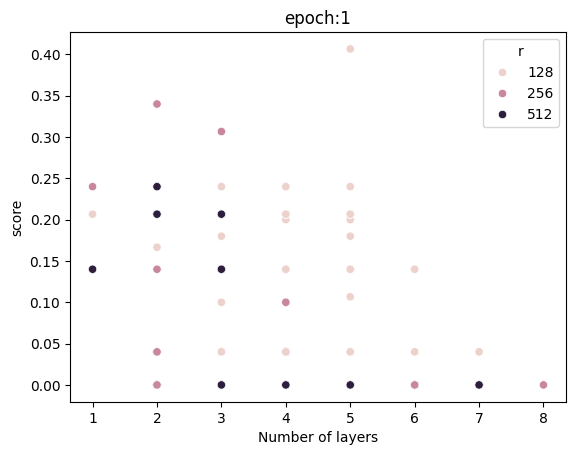

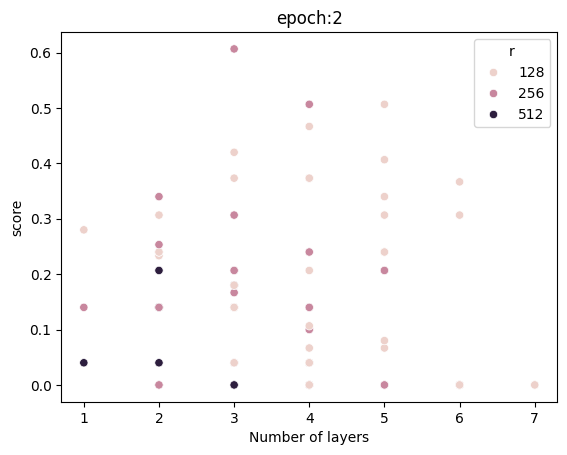

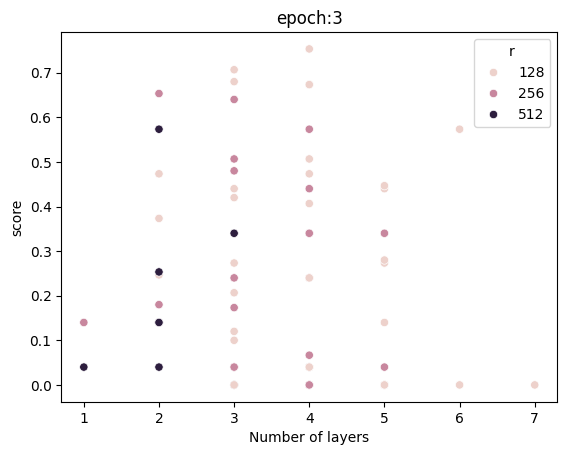

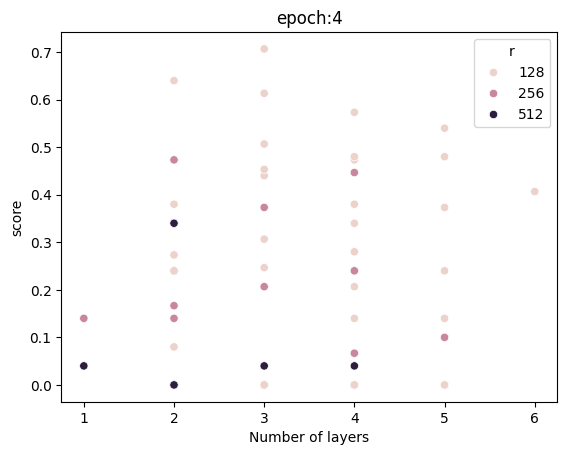

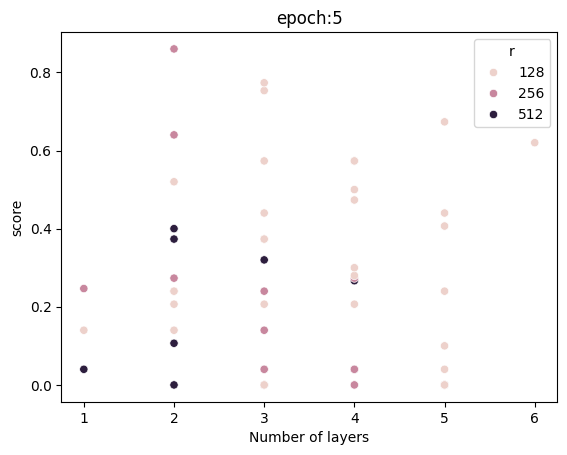

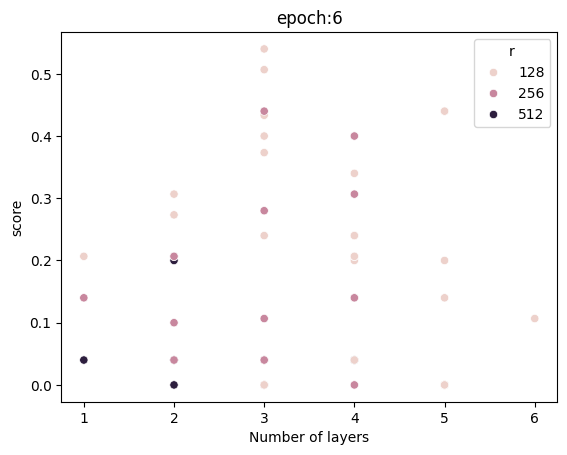

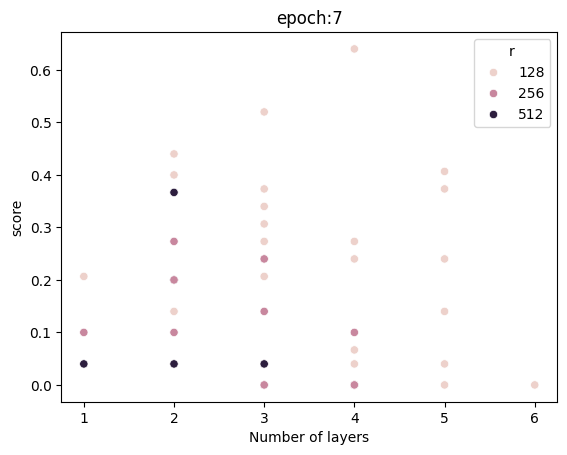

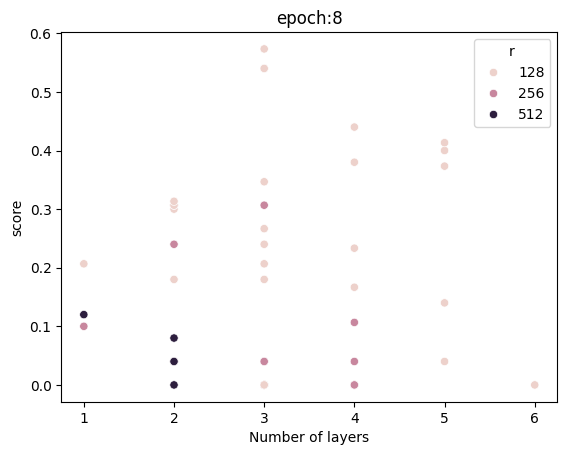

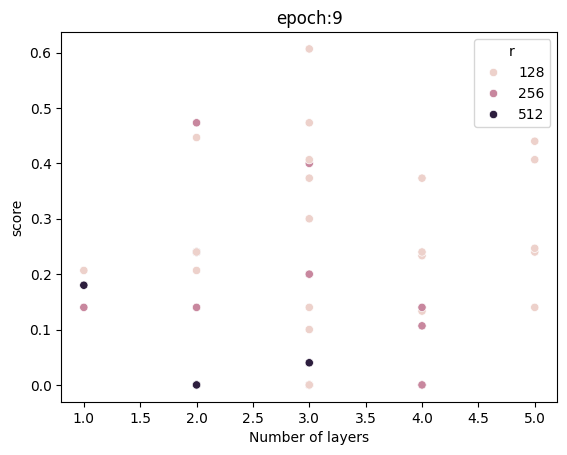

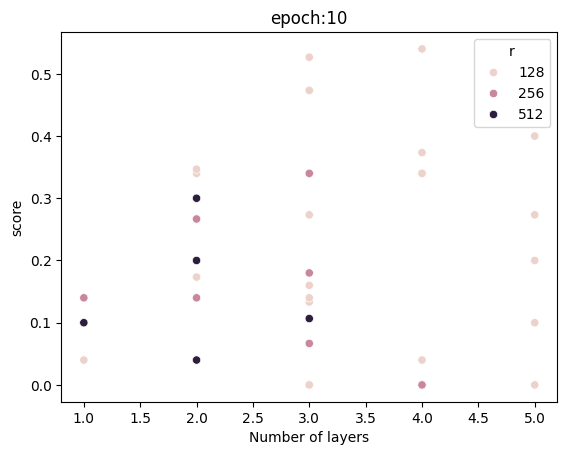

In [125]:
for e in mean_df["epoch"].unique():
    temp_df=mean_df[mean_df["epoch"]==e]
    plt.figure()
    sns.scatterplot(data=temp_df,x="Number of layers",y="score",hue="r",
                )
    plt.title(f"epoch:{e}")

<Axes: >

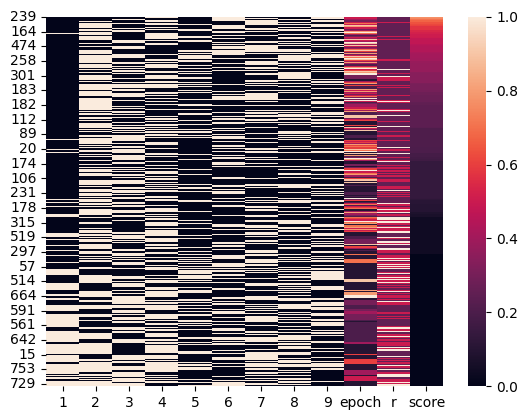

In [126]:
mean_df=mean_df.sort_values(["score"],ascending=False)
heat_df=mean_df.copy()
heat_df["epoch"]=heat_df["epoch"]/10
heat_df["r"]=heat_df["r"]/512
sns.heatmap(heat_df.drop(["Number of layers"],axis=1).astype(float))

In [134]:
heat_df[:7]

,1,2,3,4,5,6,7,8,9,epoch,r,score,Number of layers
239,0,1,0,0,0,0,0,0,1,0.5,0.50,0.860000,2
96,0,0,0,1,0,1,0,0,1,0.5,0.25,0.773333,3
278,0,1,0,0,1,0,1,0,1,0.3,0.25,0.753333,4
38,0,0,0,0,0,1,1,0,1,0.5,0.25,0.753333,3
94,0,0,0,1,0,1,0,0,1,0.3,0.25,0.706667,3
141,0,0,1,0,0,1,0,1,0,0.4,0.25,0.706667,3
139,0,0,1,0,0,1,0,1,0,0.3,0.25,0.680000,3


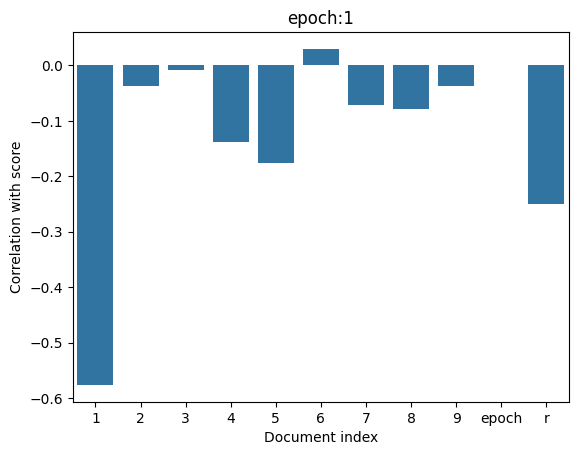

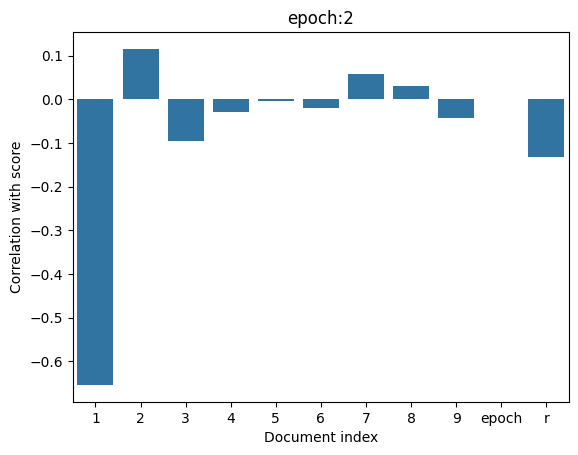

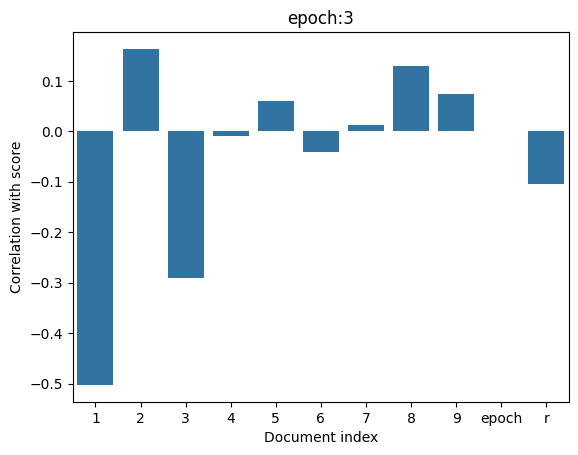

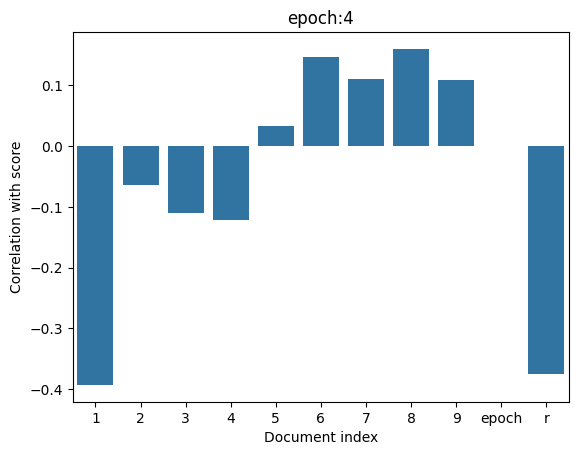

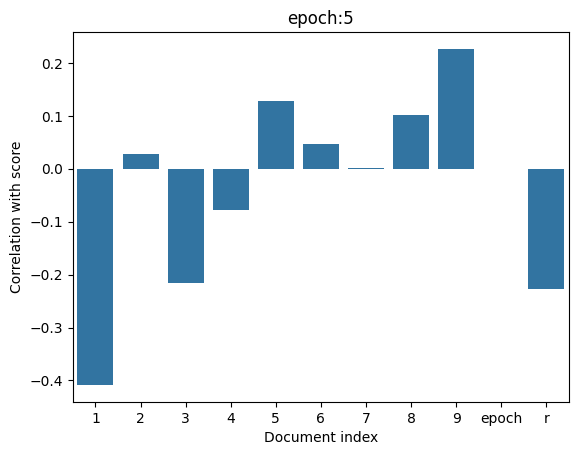

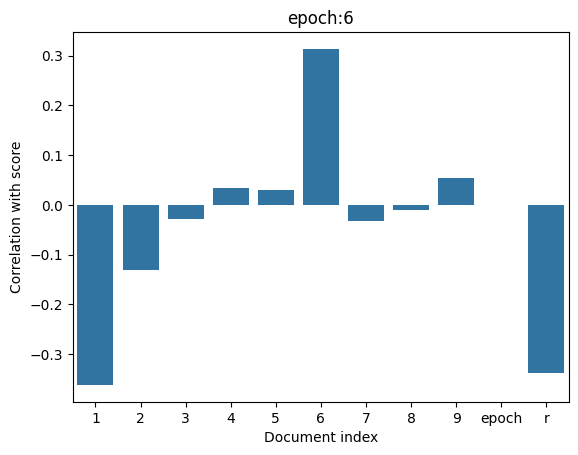

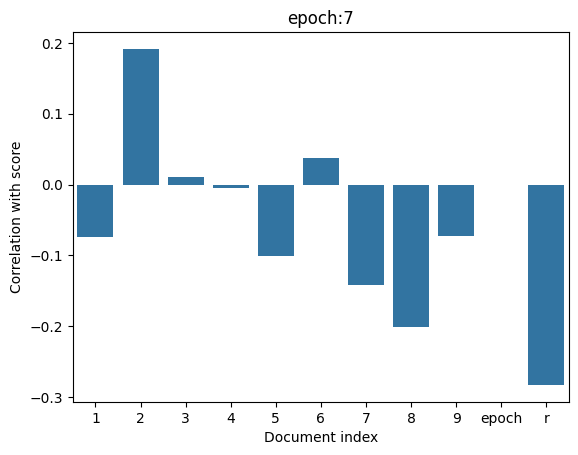

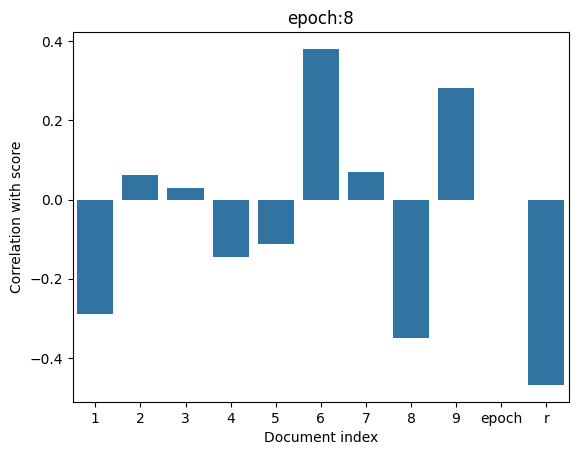

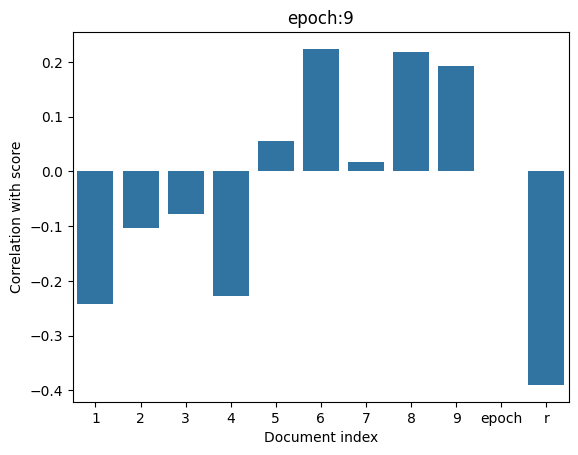

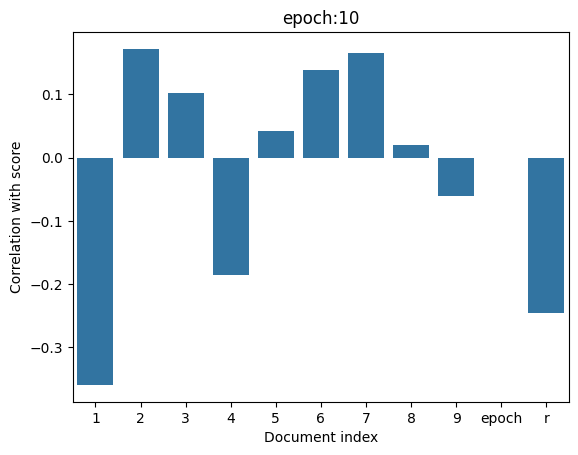

In [128]:
#heatmap


for e in sorted(mean_df["epoch"].unique()):
    temp_df=mean_df[mean_df["epoch"]==e]
    corr_df=temp_df.corr().drop(["score","Number of layers"])

    #corr_df.columns=full_lora_modules+["epoch","score","Number of layers"]
    plt.figure()
    sns.barplot(data=corr_df["score"])
    plt.ylabel("Correlation with score")
    plt.xlabel("Document index")
    plt.title(f"epoch:{e}")

In [129]:
full_lora_modules = [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]

In [130]:
2,9

(2, 9)

In [131]:
#k,o,down